In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import plotly.express as px


In [2]:
total_viviendas = 33_162_148

In [3]:
f = '../data/001_raw/ENCEVI_2018/vivienda.csv'
entidad = pd.read_csv(f,usecols=['folio','entidad'],index_col=0)

In [4]:
f ="../data/002_intermediate/vivienda_con_aa.parquet"
viv =pd.read_parquet(f)
viv.factor.sum()

viv = viv.join(entidad,how='inner')
viv = viv[viv['entidad']==26]
del viv['entidad']
viv

,clima,factor,personas,m2,estrato,kwh_mes,kwh_m2,kwh_persona,kwh_m2persona
folio,,,,,,,,,
22570,Cálido extremoso,945,1,100.0,Medio alto,105.825989,1.022985,102.298456,1.022985
22571,Cálido extremoso,945,2,150.0,Medio alto,1183.100599,7.624426,571.831956,3.812213
22572,Cálido extremoso,945,2,200.0,Medio alto,259.916011,1.256261,125.626072,0.628130
22577,Cálido extremoso,1044,1,150.0,Medio alto,39.444723,0.622350,93.352510,0.622350
22578,Cálido extremoso,1044,3,200.0,Medio alto,127.276477,1.293978,86.265168,0.431326
...,...,...,...,...,...,...,...,...,...
23449,Cálido extremoso,795,3,150.0,Medio bajo,51.626658,0.676883,33.844142,0.225628
23450,Cálido extremoso,795,3,55.0,Medio bajo,117.842885,4.213776,77.252558,1.404592
23451,Cálido extremoso,795,2,75.0,Medio bajo,46.712113,1.224895,45.933577,0.612448


In [5]:
viv.factor.sum()

np.int64(479503)

In [6]:

# --- 1) Función para calcular cuantiles ponderados ---
def cuantil_ponderado(valores, percentiles, pesos):
    v = np.array(valores)
    w = np.array(pesos)
    orden = np.argsort(v)
    v_ord, w_ord = v[orden], w[orden]
    cumw = np.cumsum(w_ord)
    cumw_norm = cumw / cumw[-1]
    return np.interp(percentiles, cumw_norm, v_ord)

# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes(df):
    vals = df['kwh_mes'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })


# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes_persona(df):
    vals = df['kwh_persona'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })
# --- 2) Estadísticos ponderados sobre kwh_mes ---
def estadisticas_kwh_mes_persona_area(df):
    vals = df['kwh_m2persona'].values
    wts  = df['factor'].values
    return pd.Series({
        'P25':     cuantil_ponderado(vals, [0.25], wts)[0],
        'Mediana': cuantil_ponderado(vals, [0.50], wts)[0],
        'Media':   np.average(vals, weights=wts),
        'P75':     cuantil_ponderado(vals, [0.75], wts)[0]
    })

In [7]:
f = "../data/002_intermediate/porcentajes_aa.parquet"
porcentajes_aa = pd.read_parquet(f)

In [8]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes)
    .reset_index()
)
grouped =  pd.concat([grouped,porcentajes_aa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmes = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75',"porcentaje"]]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |   porcentaje |
|-------:|-------:|----------:|--------:|-------:|-------------:|
|  30.00 |  39.09 |     44.91 |  100.10 |  99.95 |         0.03 |
|  55.00 | 106.46 |    149.23 |  212.90 | 258.63 |         0.01 |
|  75.00 |  75.10 |    119.66 |  129.24 | 157.00 |         0.05 |
| 100.00 | 174.76 |    200.88 |  269.78 | 269.90 |         0.65 |
| 150.00 |  98.13 |    134.82 |  218.76 | 214.20 |         0.04 |
| 200.00 | 285.98 |    285.98 |  285.98 | 285.98 |         0.09 |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |    P25 |   Mediana |   Media |    P75 |   porcentaje |
|-------:|-------:|----------:|--------:|-------:|-------------:|
|  30.00 |  43.46 |    113.62 |  137.93 | 176.68 |         0.12 |
|  55.00 |  62.83 |    139.55 |  181.48 | 233.37 |         0.00 |
|  75.00 |  74.26 |    139.22 |  177.95 | 257.05 |      

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_9550/2173147482.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes)


In [10]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes_persona)
    .reset_index()
)


grouped =  pd.concat([grouped,porcentajes_aa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmespersona = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75']]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |    P25 |   Mediana |   Media |    P75 |
|-------:|-------:|----------:|--------:|-------:|
|  30.00 |  19.87 |     22.89 |   51.57 |  51.49 |
|  55.00 |  48.49 |     72.87 |  100.17 | 109.92 |
|  75.00 |  59.85 |     67.96 |   89.83 | 102.76 |
| 100.00 |  87.44 |    108.64 |  168.79 | 212.88 |
| 150.00 |  85.86 |    101.99 |  188.53 | 129.76 |
| 200.00 | 193.83 |    193.83 |  193.83 | 193.83 |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |   P25 |   Mediana |   Media |    P75 |
|-------:|------:|----------:|--------:|-------:|
|  30.00 | 37.48 |     54.39 |   57.77 |  64.48 |
|  55.00 | 41.65 |     54.97 |   86.01 |  92.69 |
|  75.00 | 35.06 |     64.15 |   95.90 | 128.30 |
| 100.00 | 43.33 |     73.15 |   98.61 | 128.09 |
| 150.00 | 50.44 |     72.43 |  103.54 | 124.72 |
| 200.00 | 55.54 |    133.41 |  124.49 | 164.34 |
: Estadísticas ponderadas de consumo tot

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_9550/954292148.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes_persona)


In [11]:

# --- 3) Filtrado inicial ---
tamanos  = [30, 55, 75, 100, 150, 200]
estratos = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']

viv_tab = viv[viv['m2'].isin(tamanos)].copy()

# --- 4) Agrupar y calcular estadísticas ---
grouped = (
    viv_tab
    .groupby(['m2','clima','estrato'], observed=True)
    .apply(estadisticas_kwh_mes_persona_area)
    .reset_index()
)


grouped =  pd.concat([grouped,porcentajes_aa[["porcentaje","viviendas"]]],axis=1)
grouped_kwhmespersonaarea = grouped.copy()

# --- 5) Generar tablas Markdown ---
for clima in grouped['clima'].unique():
    for estrato in estratos:
        sub = grouped[
            (grouped['clima']==clima) &
            (grouped['estrato']==estrato)
        ]
        if sub.empty:
            continue

        # 6) Pivot: m2 en filas, percentiles en columnas en el orden correcto
        tabla = (
            sub
            .set_index('m2')[['P25','Mediana','Media','P75']]
            .reindex(tamanos)
            .rename_axis('m²')
            .round(2)
            .reset_index()
        )

        # 7) Generar slug y etiqueta Quarto
        slug_clima   = clima.lower().replace(' ','-').replace('í','i').replace('á','a')
        slug_estrato = estrato.lower().replace(' ','-')
        etiqueta     = f"tbl-{slug_clima}-{slug_estrato}"

        # 8) Imprimir en Markdown
        print(tabulate(
            tabla,
            headers=tabla.columns,
            tablefmt='pipe',
            floatfmt='.2f',
            showindex=False
        ))
        print(
            f": Estadísticas ponderadas de consumo total mensual (KWh) para clima **{clima}**, "
            f"estrato socioeconómico **{estrato}** {{#{etiqueta}}}\n"
        )

|     m² |   P25 |   Mediana |   Media |   P75 |
|-------:|------:|----------:|--------:|------:|
|  30.00 |  0.66 |      0.76 |    1.72 |  1.72 |
|  55.00 |  0.88 |      1.32 |    1.82 |  2.00 |
|  75.00 |  0.80 |      0.91 |    1.20 |  1.37 |
| 100.00 |  0.87 |      1.09 |    1.69 |  2.13 |
| 150.00 |  0.57 |      0.68 |    1.26 |  0.87 |
| 200.00 |  0.97 |      0.97 |    0.97 |  0.97 |
: Estadísticas ponderadas de consumo total mensual (KWh) para clima **Cálido extremoso**, estrato socioeconómico **Bajo** {#tbl-calido-extremoso-bajo}

|     m² |   P25 |   Mediana |   Media |   P75 |
|-------:|------:|----------:|--------:|------:|
|  30.00 |  1.25 |      1.81 |    1.93 |  2.15 |
|  55.00 |  0.76 |      1.00 |    1.56 |  1.69 |
|  75.00 |  0.47 |      0.86 |    1.28 |  1.71 |
| 100.00 |  0.43 |      0.73 |    0.99 |  1.28 |
| 150.00 |  0.34 |      0.48 |    0.69 |  0.83 |
| 200.00 |  0.28 |      0.67 |    0.62 |  0.82 |
: Estadísticas ponderadas de consumo total mensual (KWh) para cl

/var/folders/tc/1tpm30d53_9458mzx73ydg_w0000gn/T/ipykernel_9550/12594808.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(estadisticas_kwh_mes_persona_area)


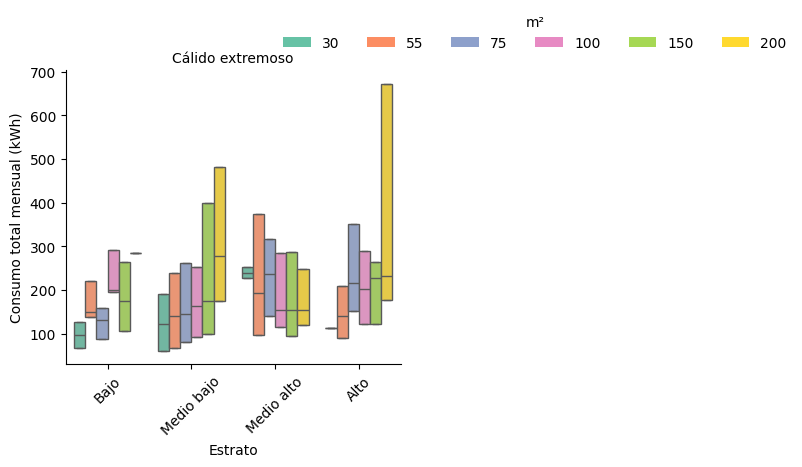

In [12]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_mes',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual (kWh)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


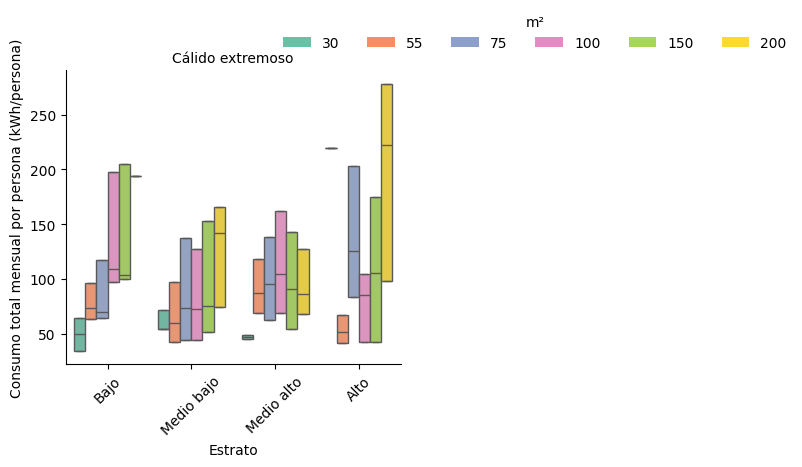

In [13]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual por persona (kWh/persona)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


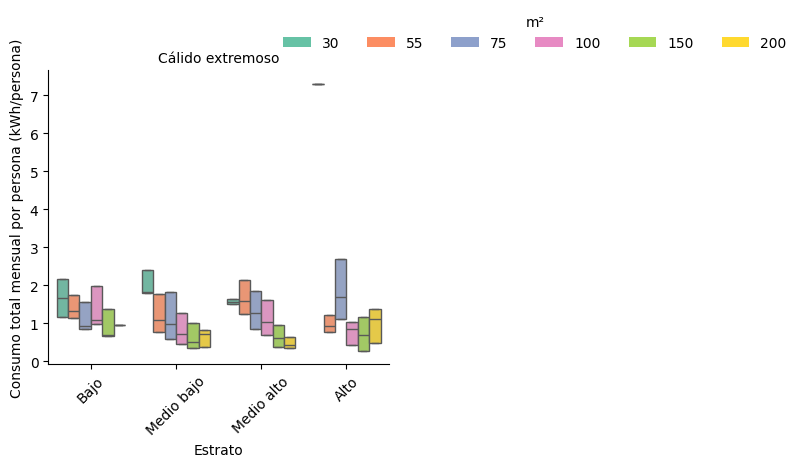

In [14]:
#| label: fig-total
#| fig-cap: Consumo total mensual de la vivienda para los diferentes climas y estratos socioeconómicos y sin uso de aire acondicionado.
estrato_order = ['Bajo', 'Medio bajo', 'Medio alto', 'Alto']
m2_list = sorted(viv['m2'].unique())

# 2) Crea tu palette y un dict m2→color
colors = sns.color_palette('Set2', n_colors=len(m2_list))
palette_dict = {m2: colors[i] for i, m2 in enumerate(m2_list)}

# 3) Dibuja el catplot SIN leyenda
g = sns.catplot(
    data=viv,
    x='estrato',
    y='kwh_m2persona',
    hue='m2',
    palette=palette_dict,
    col='clima',
    kind='box',
    order=estrato_order,
    col_wrap=3,
    height=4,
    sharey=True,
    whis=[25,75],
    showfliers=False,
    legend=False      # importante: no leyenda automática
)

# 4) Formatea ejes y títulos
g.set_axis_labels("Estrato", "Consumo total mensual por persona (kWh/persona)")
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# 5) Construye los patches manualmente
patches = [
    Patch(facecolor=palette_dict[m], label=str(int(m)))
    for m in m2_list
]

# 6) Añade la leyenda centrada un poco a la izquierda
g.fig.legend(
    handles=patches,
    title="m²",
    loc="upper center",
    bbox_to_anchor=(0.45, 1.05),  # ajusta este 0.45 para moverla más a la izquierda/derecha
    ncol=len(m2_list),
    frameon=False
)

# 7) Ajusta márgenes
g.fig.subplots_adjust(top=0.88, right=0.92)

plt.show()


In [15]:
grouped_kwhmes["etotal"] = grouped_kwhmes.Media*grouped_kwhmes.viviendas
grouped_kwhmes.sort_values(by="etotal",ascending=False)

,m2,clima,estrato,P25,Mediana,Media,P75,porcentaje,viviendas,etotal
23,200.0,Cálido extremoso,Medio bajo,171.608069,278.320763,372.867685,476.703829,0.979861,324943.0,1.211607e+08
13,100.0,Cálido extremoso,Bajo,174.760831,200.884083,269.781142,269.900685,0.646143,214275.0,5.780735e+07
22,200.0,Cálido extremoso,Medio alto,118.107749,153.205399,273.682504,249.636361,0.581802,192938.0,5.280375e+07
20,200.0,Cálido extremoso,Alto,148.178912,222.390271,497.541986,655.216571,0.246956,81896.0,4.074670e+07
12,100.0,Cálido extremoso,Alto,110.963603,172.724213,346.764933,252.708732,0.228619,75815.0,2.628998e+07
...,...,...,...,...,...,...,...,...,...,...
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027016,8959.0,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037597,12468.0,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012427,4121.0,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050618,16786.0,NaN


In [16]:
# Opción 1: Seleccionar las 4 columnas tras ordenar
df_vis = (
    grouped_kwhmes
      .sort_values(by="etotal", ascending=False)
      [["m2","clima","estrato","viviendas","etotal"]]
      .reset_index(drop=True)
)
display(df_vis)


,m2,clima,estrato,viviendas,etotal
0,200.0,Cálido extremoso,Medio bajo,324943.0,1.211607e+08
1,100.0,Cálido extremoso,Bajo,214275.0,5.780735e+07
2,200.0,Cálido extremoso,Medio alto,192938.0,5.280375e+07
3,200.0,Cálido extremoso,Alto,81896.0,4.074670e+07
4,100.0,Cálido extremoso,Alto,75815.0,2.628998e+07
...,...,...,...,...,...
63,NaN,NaN,NaN,8959.0,NaN
64,NaN,NaN,NaN,12468.0,NaN
65,NaN,NaN,NaN,4121.0,NaN
66,NaN,NaN,NaN,16786.0,NaN


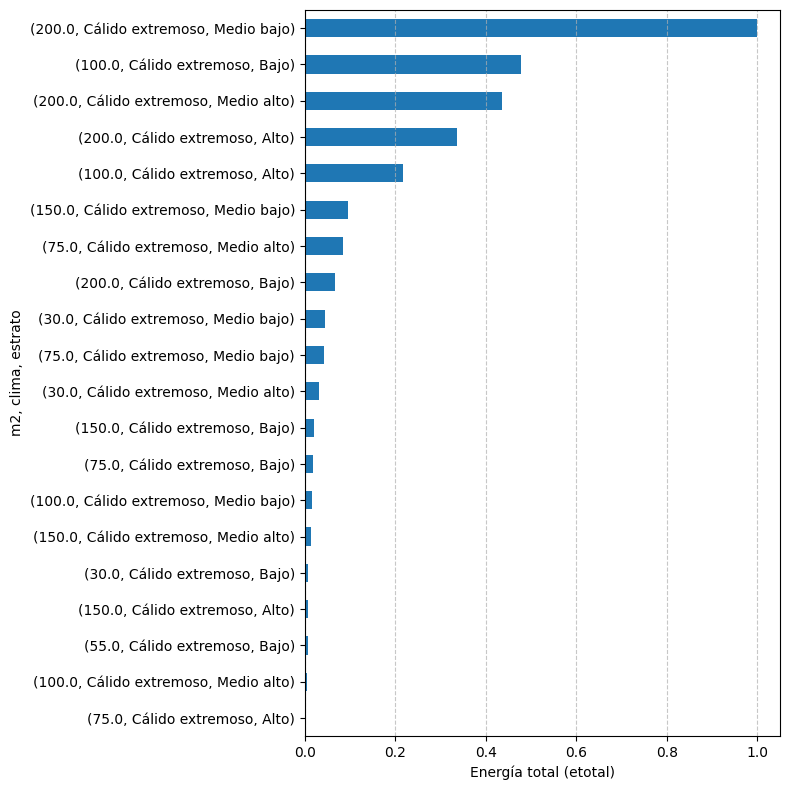

In [17]:

# Prepara Serie normalizada (ya la tienes)
et = (
    grouped_kwhmes
      .sort_values(by="etotal", ascending=False)
      .set_index(["m2","clima","estrato"])["etotal"]
      .head(20)
)
et = et / et.max()

# Grafica horizontal
plt.figure(figsize=(8, 8))
# Para que la barra más grande quede arriba, ordena de menor a mayor
et.sort_values().plot(kind='barh')

plt.xlabel("Energía total (etotal)")
plt.ylabel("m2, clima, estrato")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [18]:
grouped_kwhmes

,m2,clima,estrato,P25,Mediana,Media,P75,porcentaje,viviendas,etotal
0,30.0,Cálido extremoso,Alto,113.406372,113.406372,113.406372,113.406372,0.003353,1112.0,1.261079e+05
1,30.0,Cálido extremoso,Bajo,39.089615,44.909086,100.104134,99.950312,0.028499,9451.0,9.460842e+05
2,30.0,Cálido extremoso,Medio alto,215.326552,221.499585,243.721437,243.284128,0.046803,15521.0,3.782800e+06
3,30.0,Cálido extremoso,Medio bajo,43.458311,113.617599,137.926904,176.676295,0.119676,39687.0,5.473905e+06
4,55.0,Cálido extremoso,Alto,88.872908,89.923539,156.116456,189.422913,0.000645,214.0,3.340892e+04
...,...,...,...,...,...,...,...,...,...,...
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027016,8959.0,NaN
64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.037597,12468.0,NaN
65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012427,4121.0,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.050618,16786.0,NaN


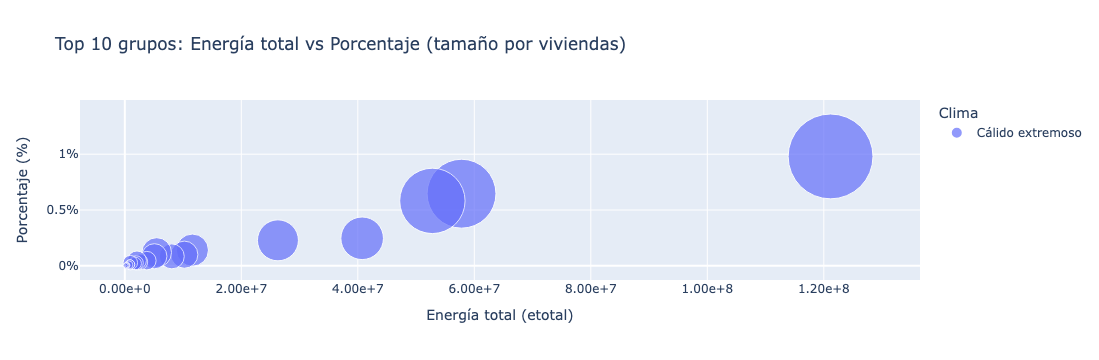

In [19]:

# Ordenar y seleccionar top 10 grupos por etotal
df_top10 = (
    grouped_kwhmes
    .sort_values(by='etotal', ascending=False)
    # .head(30)
    .reset_index()
)

# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    df_top10,
    x='etotal',
    y='porcentaje',
    size='viviendas',
    color='clima',
    hover_data=['m2', 'estrato', 'viviendas', 'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (etotal)',
        'porcentaje': 'Porcentaje (%)',
        'viviendas': 'Número de viviendas',
        'clima': 'Clima'
    },
    title='Top 10 grupos: Energía total vs Porcentaje (tamaño por viviendas)',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(ticksuffix="%")
)

fig.show()


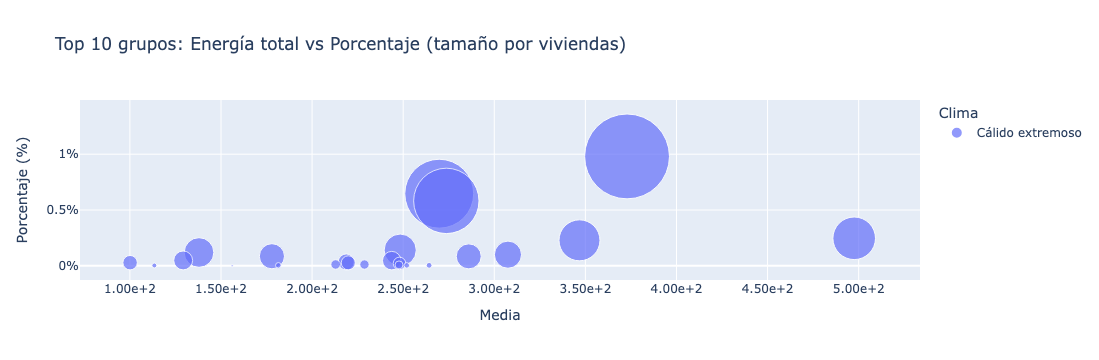

In [20]:

# Ordenar y seleccionar top 10 grupos por etotal
df_top10 = (
    grouped_kwhmes
    .sort_values(by='etotal', ascending=False)
    # .head(30)
    .reset_index()
)

# Crear gráfica de burbujas: etotal vs porcentaje, tamaño por viviendas, color por clima
fig = px.scatter(
    df_top10,
    x='Media',
    y='porcentaje',
    size='viviendas',
    color='clima',
    hover_data=['m2', 'estrato', 'viviendas', 'porcentaje', 'etotal'],
    labels={
        'etotal': 'Energía total (etotal)',
        'porcentaje': 'Porcentaje (%)',
        'viviendas': 'Número de viviendas',
        'clima': 'Clima'
    },
    title='Top 10 grupos: Energía total vs Porcentaje (tamaño por viviendas)',
    size_max=60
)

fig.update_layout(
    xaxis=dict(tickformat=".2e"),
    yaxis=dict(ticksuffix="%")
)

fig.show()
